# Documentation

we first use opencv to initialize the binary image, that is the only usage of opencv in this code piece, the rest of the functions do not use any functionalliyu of opencv.

then after loading the image we make sure that its a binary image by dividing every pixel value by 255 and making the image's data type as integer, since 0.any_num is 0 in terms of integer and 255/255 is 1, we have a binary image.

then we continue by defining the 4 required structuring elements ats its decsribed in the chapter 9.5 of woods and gozalez.

# Erosion

the functionallity of erosion is simple, it simply checks if all the 1s in structuring element fits inside the binary image which is simply 1s. For the sake of simplicity and efficiency, we use numpy's functions to check if all 1s fit in. In the upcoming functions we also use numpy's functions to describe union and intersection as logical ors and logical ands.

# hit_or_miss

the definition of hit or miss is simple, so the code fully replicates the definition of hit oe miss function by using numpy.

# find_foregorud_extremes

this function simply calculates the peak points of the cat image, it actually calculates the max and lowest row and column number of any image given as parameter but in this case it finds the max and min column and row numbers which again uses numpy to find 1s in binary image and picks the max/min values.
This function will provide reference for the part that will be used to filter out extensive thickening operation done by convex hull function for each structuring element.
# convex_hull
finds the convex hull of a binary image given as parameter, this function iteratively updates the parameter by using hit or miss and logically_or function of numpy, we logically or because it serves as union operator for binary images since 1 + 0 = 1 in boolean algebra as well as 1+1 = 1. so we union 2 images with that. we continue once we have kth image which is exactly same as k-1th image. we repeat this process for each structuring element. then call find_foregorud_extremes to get the final convex hull.




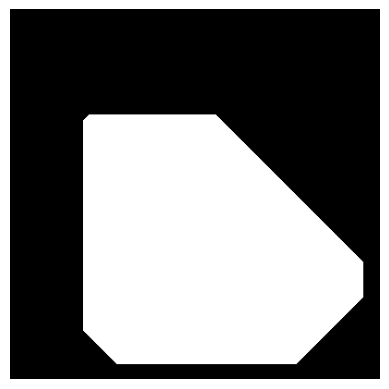

In [27]:
import cv2
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


image = cv2.imread('/content/drive/MyDrive/perfectly_painted_cat.png', cv2.IMREAD_GRAYSCALE)

_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

binary_image = binary_image / 255

binary_image = binary_image.astype(int)

B1 = np.array([[1, 0, 0],
               [1, 0, 0],
               [1, 0, 0]])

B2 = np.array([[1, 1, 1],
               [0, 0, 0],
               [0, 0, 0]])

B3 = np.array([[0, 0, 1],
               [0, 0, 1],
               [0, 0, 1]])

B4 = np.array([[0, 0, 0],
               [0, 0, 0],
               [1, 1, 1]])

BE = np.array([[0, 0, 0],
               [0, 1, 0],
               [0, 0, 0]])


def erosion(binary_image, struct_element):
    height, width = binary_image.shape
    se_height, se_width = struct_element.shape

    offset_y = se_height // 2
    offset_x = se_width // 2
    eroded_image = np.zeros_like(binary_image)

    for i in range(offset_y, height - offset_y):
        for j in range(offset_x, width - offset_x):
            region = binary_image[i - offset_y:i + offset_y + 1, j - offset_x:j + offset_x + 1]
            if np.all(region[struct_element == 1]):
                eroded_image[i, j] = 1
    return eroded_image

def hit_or_miss(img, B, Bg):
    return np.logical_and(erosion(img, B), erosion(np.logical_not(img), Bg))

def find_foreground_extremes(img):
    rows, cols = np.where(img == 1)

    if not rows.size or not cols.size:
        return None
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)

    return min_row, max_row, min_col, max_col


def convex_hull(img):
    start_img = img.copy()
    prev_img = img.copy()
    for B in [B1, B2, B3, B4]:
        while True:
            hit_or_miss_result = hit_or_miss(prev_img, B, BE)
            img = np.logical_or(prev_img, hit_or_miss_result)
            if np.array_equal(prev_img, img):
                break
            prev_img = img.copy()


    extremes = find_foreground_extremes(start_img)
    min_row, max_row, min_col, max_col = extremes
    filter = np.zeros(img.shape)
    filter[min_row:max_row+1, min_col:max_col+1] = 1
    result = np.logical_and(img, filter)
    return result


convex_hull_image = convex_hull(binary_image)
plt.imshow(convex_hull_image, cmap='gray')
plt.axis('off')
plt.show()